# Start detection

In [4]:
#Video used as an example and its associated soundtrack
video_path = 'videos/video.mp4'
audio_path = 'videos/video.wav'

## First method

In [1]:
from pyAudioAnalysis import MidTermFeatures as aFm
from pyAudioAnalysis import audioBasicIO as aIO
import moviepy.editor as mp
import numpy as np
import matplotlib.pyplot as plt
import csv
import IPython.display as ipd
import librosa
from collections import Counter

C:\Users\nicol\anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [9]:
def extract_time_start(video_path, bip_ref_path="ref_bip_isolated.wav", figure = None):
    # features of the ref
    # extract short-term features using a 50msec non-overlapping windows
    fs, s_ref = aIO.read_audio_file(bip_ref_path)
    duration = len(s_ref) / float(fs)
    #print(duration)
    win, step = 0.05, 0.05
    win_mid, step_mid = duration, 0.5
    mt_ref, st_ref, mt_n_ref = aFm.mid_feature_extraction(s_ref, fs, win_mid * fs, step_mid * fs, win * fs, step * fs)
    # extraction on the long signal
    my_clip1 = mp.VideoFileClip(video_path)
    fs = 44100
    s_long = my_clip1.audio.to_soundarray(fps=fs)
    s_long = s_long[:, 0]
    duration_long = len(s_long) / float(fs)

    # extract short-term features using a 50msec non-overlapping windows
    win, step = 0.05, 0.05
    win_mid, step_mid = 0.4, 0.05
    mt_long, st_long, mt_n_long = aFm.mid_feature_extraction(s_long, fs, win_mid * fs, step_mid * fs, win * fs, step * fs)
    
    # normalisation 
    mt_long = mt_long.T
    for i in range(len(mt_long)):
        mt_long[i] = mt_long[i]/np.linalg.norm(mt_long[i])
    mt_long = mt_long.T
    mt_ref = mt_ref/np.linalg.norm(mt_ref)

    # compute the distance and get the minimum
    distances = np.linalg.norm(mt_long - mt_ref, axis=0)
    
    if figure == 'features':
    # To represent the features of the reference beep and the detected beep
        plt.plot(mt_ref, label='Reference')
        plt.plot(mt_long.T[np.argmin(distances)], label='Beep detected')
        plt.xlabel('Features')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()

    if figure == 'distances':
    # To represent the graph of the distances
        x = []
        for i in range(len(distances)):
            x.append(i * duration_long / mt_long.shape[1])
        plt.plot(x,distances)
        plt.grid(True)
        plt.xlabel('Time(in s)')
        plt.ylabel('Distance')

    time_start = np.argmin(distances) * duration_long / mt_long.shape[1]

    return time_start

Start time at : 18.51302816901409 s


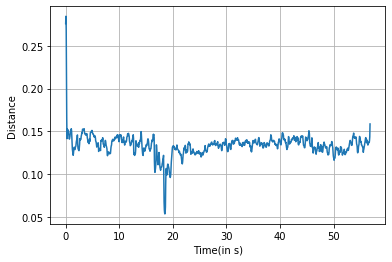

In [11]:
start_time = extract_time_start(video_path, figure = "distances")
print("Start time at :",start_time,"s")
y, sr = librosa.load(audio_path, offset = start_time, duration = 0.4)
ipd.Audio(y, rate=sr)

## Improvement of the first method

The following function returns a list of all the possible start time of a video, ranked from most likely to least likely.

In [16]:
def extract_time_allbip(video_path, bip_ref_path="ref_bip_isolated.wav", references_path = "ref_features_35bip.npy", figure = None):
    mt = np.load(references_path)
    fs, s_ref = aIO.read_audio_file(bip_ref_path)
    duration = len(s_ref) / float(fs)
    win, step = 0.05, 0.05
    win_mid, step_mid = duration, 0.5

    # extraction on the long signal
    my_clip1 = mp.VideoFileClip(video_path)
    fs = 44100
    s_long = my_clip1.audio.to_soundarray(fps=fs)
    s_long = s_long[:, 0]
    duration_long = len(s_long) / float(fs)

    # extract short-term features using a 50msec non-overlapping windows
    win, step = 0.05, 0.05
    win_mid, step_mid = 0.4, 0.05
    mt_long, st_long, mt_n_long = aFm.mid_feature_extraction(s_long, fs, win_mid * fs, step_mid * fs,
                                                             win * fs, step * fs)

    #normalization
    mt_long = mt_long.T            
    for i in range(len(mt_long)):
        mt_long[i] = mt_long[i]/np.linalg.norm(mt_long[i])

    possible_time = []
    
    for i in range(len(mt)):
        arg_min_dist = 0
        min_dist = 1000        
        distances = []
        
        for j in range(len(mt_long)):
            distances.append(np.linalg.norm(mt_long[j] - mt[i]))
            if np.linalg.norm(mt[i]-mt_long[j]) < min_dist :
                arg_min_dist = j
                min_dist = np.linalg.norm(mt[i]-mt_long[j])
                
        if figure == 'distances':
            x = []
            for i in range(len(distances)):
                x.append(i * duration_long / mt_long.shape[1])
            plt.plot(x,distances)
            plt.grid(True)
            plt.xlabel('Time(in s)')
            plt.ylabel('Distance')
        
        possible_time.append(arg_min_dist * duration_long / mt_long.shape[0])       
    
    time_sorted = [i[0] for i in Counter(possible_time).most_common()]
    
    return time_sorted

Start time at : 18.863274647887323 s


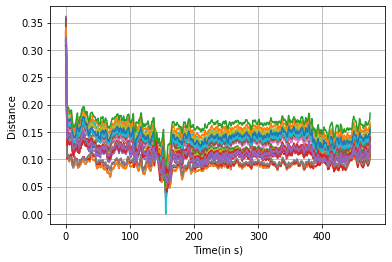

In [15]:
start_time = extract_time_allbip(video_path, figure = 'distances')[0]
print("Start time at :",start_time,"s")
y, sr = librosa.load(audio_path, offset = start_time - 0.1, duration = 0.5)
ipd.Audio(y, rate=sr)

In [17]:
start_time = extract_time_allbip(video_path)
print("List of the possible start times :", start_time)

List of the possible start times : [18.863274647887323, 18.6631338028169, 18.613098591549296, 19.413661971830987, 18.412957746478874, 19.013380281690143, 18.713169014084507, 18.91330985915493, 19.313591549295776, 18.312887323943663, 18.763204225352112]


## Second method

For this section, download the dataset of beeps at this link : https://drive.google.com/drive/folders/1ZG3SaLlpEdosN2ELhiTWztWCgkyQqkHt

In [72]:
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

In [73]:
# Set REBUILD_DATA to False after one running
REBUILD_DATA = True

In [74]:
class BeepData():
    IMG_SIZE = 128
    Beep = "dataset/beeps"
    Non_Beep = "dataset/non-beeps"
    LABELS = {Beep : 0, Non_Beep : 1}
    training_data = []
    
    #Number of Beep and Non-Beep
    Beep_count = 0
    Non_Beep_count = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                path = os.path.join(label,f)
                y, sr = librosa.load(path, duration=0.49)
                ps = librosa.feature.melspectrogram(y=y, sr=sr)
                
                # Normalization of the sound
                m = np.max(ps)    
                for i in range(128):
                    for j in range(22):
                        ps[i][j] = ps[i][j]/m
                
                # Resize the spectrogram
                ps = cv2.resize(ps, (self.IMG_SIZE, self.IMG_SIZE))
                
                self.training_data.append([np.array(ps), np.eye(2)[self.LABELS[label]]])
            
                if label == self.Beep:
                    self.Beep_count += 1            
                elif label == self.Non_Beep:
                    self.Non_Beep_count += 1
        
        # Shuffle the data
        np.random.shuffle(self.training_data)
        
        np.save("training_data.npy", self.training_data)
        print("Number of beep in the dataset :",self.Beep_count)
        print("Number of non beep in the dataset :",self.Non_Beep_count)

In [75]:
if REBUILD_DATA:
    Data_Training = BeepData()
    Data_Training.make_training_data()
    
training_data = np.load("training_data.npy", allow_pickle=True)

  1%|          | 3/281 [00:00<00:09, 27.91it/s]

dataset/beeps


  1%|          | 4/707 [00:00<00:21, 33.23it/s]

dataset/non-beeps


100%|██████████| 707/707 [00:22<00:00, 31.19it/s]


Number of beep in the dataset : 281
Number of non beep in the dataset : 707


In [76]:
# Definition of the CNN
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 24, 5)
        self.conv2 = nn.Conv2d(24, 48, 5)        
        self.conv3 = nn.Conv2d(48, 48, 5)

        self.fc1 = nn.Linear(2400, 64)
        self.fc2 = nn.Linear(64, 2)        
        
    def forward(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (4,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (4,2))
        x = F.relu(self.conv3(x))
        x = x.reshape(-1,2400)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
net = Net()

In [77]:
optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

In [78]:
X = torch.Tensor([i[0] for i in training_data]).view(-1, 128, 128)
y = torch.Tensor([i[1] for i in training_data])

# Percentage of the data used for testing
VAL_PCT = 0.4
val_size = int(len(X)*VAL_PCT)

#We separate the data between the training and the testing 
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

In [79]:
BATCH_SIZE = 50
EPOCHS = 50

total_loss = []
total_accuracy = []

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,128,128)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        
        loss.backward()
        optimizer.step()
    total_loss.append(loss.item())
    correct = 0
    total = 0

    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i])
            net_out = net(test_X[i].view(-1,1,128,128))[0]
            predicted_class = torch.argmax(net_out)
            if predicted_class == real_class:
                correct +=1
            total +=1
    total_accuracy.append(round(correct/total,3))

100%|██████████| 395/395 [00:03<00:00, 116.97it/s]


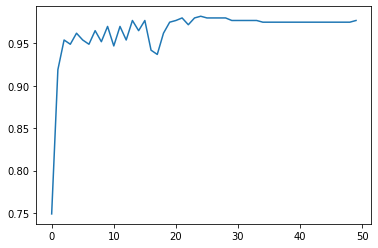

In [80]:
#Accurarcy representation depending on epochs
plt.plot(total_accuracy)

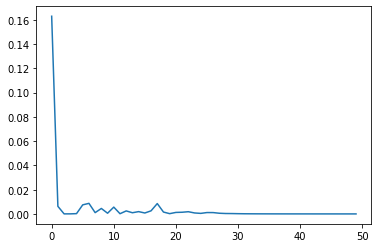

In [81]:
#Loss representation depending on epochs
plt.plot(total_loss)

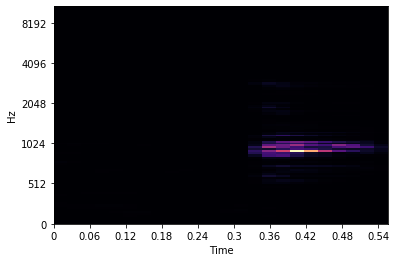

In [82]:
#Show the spectrogram of an audio 
def show_spectrogram(audio_path):
    y, sr = librosa.load(audio_path)
    ps = np.array(librosa.feature.melspectrogram(y=y, sr=sr))
    librosa.display.specshow(ps, y_axis='mel', x_axis='time')
    
show_spectrogram('Dataset/beeps/B0-0.wav')

In [83]:
#Classify an audio
def audio_classification(audio_path):
    y, sr = librosa.load(audio_path, duration=0.49)
    ps = np.array(librosa.feature.melspectrogram(y=y, sr=sr))
    m = np.max(ps)    
    for i in range(128):
        for j in range(22):
            ps[i][j] = ps[i][j]/m

    ps = cv2.resize(ps, (128, 128))
    with torch.no_grad():
        net_out = net(torch.Tensor(ps).view(-1,1,128,128))
    if net_out[0][0] >= 0.9:
        #This is a beep
        return True
    else :
        #This is a non-beep
        return False

audio_classification('Dataset/beeps/B0-0.wav')

True

In [84]:
def audio_classification_video(video_path):
    audio_path = "sound_aux.wav"
    clip = mp.AudioFileClip(video_path)
    clip.write_audiofile(audio_path, 44100)
    duration = clip.duration
    probabilites = []
    for k in range(int(duration)*4-1):
        y, sr = librosa.load(audio_path, offset=k/4, duration=0.49)
        ps = np.array(librosa.feature.melspectrogram(y=y, sr=sr))
        m = np.max(ps)    
        for i in range(128):
            for j in range(22):
                ps[i][j] = ps[i][j]/m
    
        ps = cv2.resize(ps, (128, 128))
        with torch.no_grad():
            net_out = net(torch.Tensor(ps).view(-1,1,128,128))
            probabilites.append(net_out[0][0])
    os.remove(audio_path)
    return np.argmax(probabilites)/4

In [85]:
start_time = audio_classification_video(video_path)
print("Start time at :",start_time,"s")
y, sr = librosa.load('videos/video.wav', offset = start_time - 0.5, duration = 1)
ipd.Audio(y, rate=sr)

chunk:   0%|          | 0/1254 [00:00<?, ?it/s, now=None]

MoviePy - Writing audio in sound_aux.wav


MoviePy - Done.
Start time at : 18.5 s


## Final pipeline

In [86]:
def start_detection_final(video_path):
    time_start = extract_time_allbip(video_path)
    for time in time_start:
        audio_path = "sound_aux.wav"
        clip = mp.AudioFileClip(video_path).subclip(time,time+0.5)
        clip.write_audiofile(audio_path, 44100)
        if audio_classification(audio_path):
            print("Start time at :",time,"s")
            os.remove(audio_path)
            return time
        os.remove(audio_path)
    #if all the times detected by the first method or not start-beep    
    print("Start time not detected")
    
start_detection_final(video_path)

chunk:   0%|          | 0/12 [00:00<?, ?it/s, now=None]

MoviePy - Writing audio in sound_aux.wav


MoviePy - Done.
Start time at : 18.863274647887323 s


18.863274647887323

## Data augmentation

In [87]:
from os import listdir
from os.path import isfile, join
import soundfile

Fonctions to transform an audio

In [92]:
def manipulate_pitch(path, pitch_factor):
    data, sampling_rate = librosa.load(path)
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def manipulate_noise(path, noise_factor):
    data, sampling_rate = librosa.load(path)
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

def manipulate_shift(path, shift_max, shift_direction):
    data, sampling_rate = librosa.load(path)
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    augmented_data = np.roll(data, shift)
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return augmented_data

Creation of the new beeps

In [93]:
beeps  = [f for f in listdir("Dataset/beeps/") if isfile(join("Dataset/beeps", f))]

for b in beeps :
    path = 'Dataset/beeps/' + b
    data, sampling_rate = librosa.load(path)

    #Modify shift
    new_path = "Dataset/beeps_created/shift_" + b
    shift = 'right'
    r = random.random()
    if r < 0.5 :
        shift = 'left'
    r = r/100
    data_modified = manipulate_shift(path,r,shift)
    soundfile.write(new_path,data_modified,sampling_rate)
    
    #Add noise
    new_path = "Dataset/beeps_created/noise_" + b
    r = random.random()
    r = r/100
    data_modified = manipulate_noise(path,r)
    soundfile.write(new_path,data_modified,sampling_rate)   
    
    #Modify pitch
    new_path = "Dataset/beeps_created/pitch_" + b
    r = random.random()
    r = r/100*-1
    data_modified = manipulate_pitch(path,r)
    soundfile.write(new_path,data_modified,sampling_rate) 